# Задача 3. Многоклассовая классификация и множественная классификация/регрессия

## Задача

- [x] Изучите [возможности sklearn](https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification) для решения задач **Multiclass classification**, **Multilabel classification** и **Multioutput Regression**. Основные компоненты библиотеки указаны на рисунке ниже.
![multi_org_chart](https://scikit-learn.org/stable/_images/multi_org_chart.png)

- [x] Найдите данные, на которых можно решить задачу **Multiclass classification** (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя стратегии **OneVsRest**, **OneVsOne** и **OutputCode** решите задачу **Multiclass classification** для каждого из пройденных базового алгоритма классификации (**logistic regression, svm, knn, naive bayes, decision tree**). При обучении использовать **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания.
- [x] Замерить время обучения каждой модели для каждой стратегии.
- [x] Для оценки качества моделей используйте метрику **AUC-ROC**.
- [x] Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.
- [ ] * (**+3 балла**) Повторить все пункты для задачи **Multilabel classification** (классификация с несколькими целевыми признаками, например, бинарными). В качестве стратегий попробовать **MultiOutputClassifier** и **ClassifierChain**.
- [ ] * (**+2 балла**) Повторить все пункты для задачи **Multioutput Regression** (регрессия с несколькими целевыми признаками, вещественными). Модель попробовать как минимум одну: **Ridge**. В качестве стратегий попробовать **MultiOutputRegressor** и **RegressorChain**. В качестве метрики использовать **R2**.

In [183]:
from collections import Counter

# Необходимые импорты
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Датасет

In [124]:
df = pd.read_csv("data/glass.csv")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## Описание датасета

- RI: refractive index
- Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
- Mg: Magnesium
- Al: Aluminum
- Si: Silicon
- K: Potassium
- Ca: Calcium
- Ba: Barium
- Fe: Iron
- Type of glass: (class attribute)
-- 1 buildingwindowsfloatprocessed
-- 2 buildingwindowsnonfloatprocessed
-- 3 vehiclewindowsfloatprocessed
-- 4 vehiclewindowsnonfloatprocessed (none in this database)
-- 5 containers
-- 6 tableware
-- 7 headlamps

Необходимо решить задачу многоклассовой классификации для определения типа стекла.

# EDA

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Видим, что в датасете нет отсутствующих значений

In [126]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Можем заметить, что значения масштабированы не одинаково. Так, Na и Mg имеют различные средние значения.

Посмотрим на количества стекол различных типов.

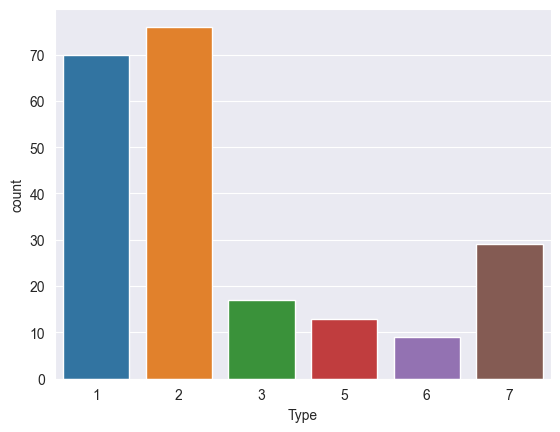

In [127]:
sns.countplot(x="Type", data=df)
plt.show()

Видим, что датасет весьма не сбалансирован, больше всего мы видим значений у типа 2 и 1, у остальных значительно меньше.

Посмотрим на распределения признаков.

/var/folders/9h/f99m03lx2cn04sktzgjwkl_h0000kt/T/ipykernel_33836/4204508732.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)


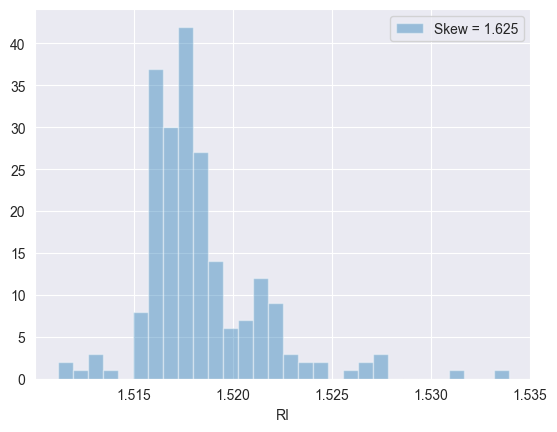

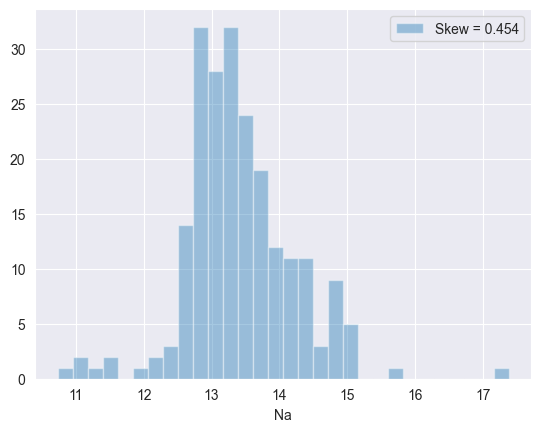

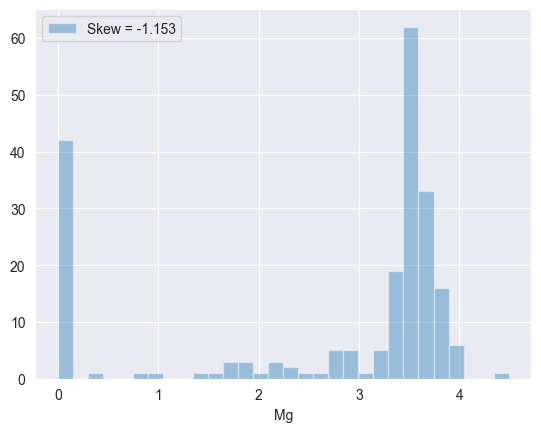

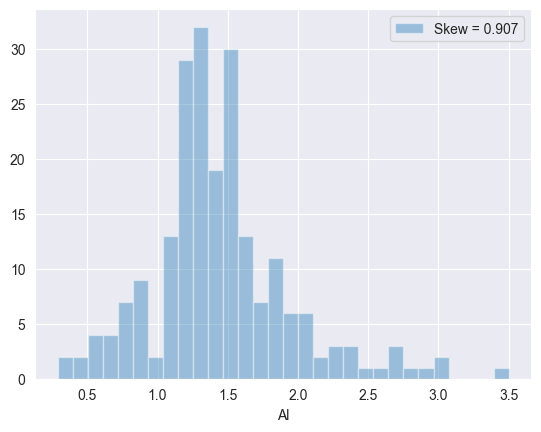

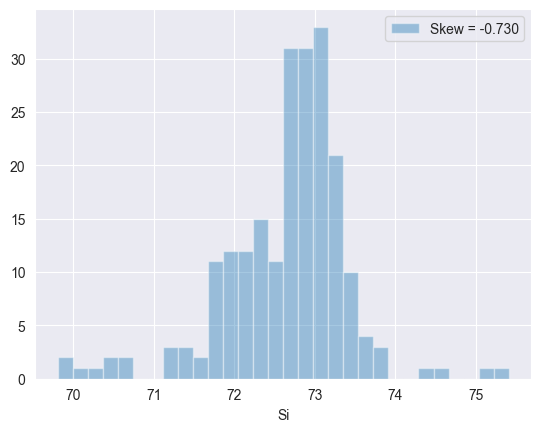

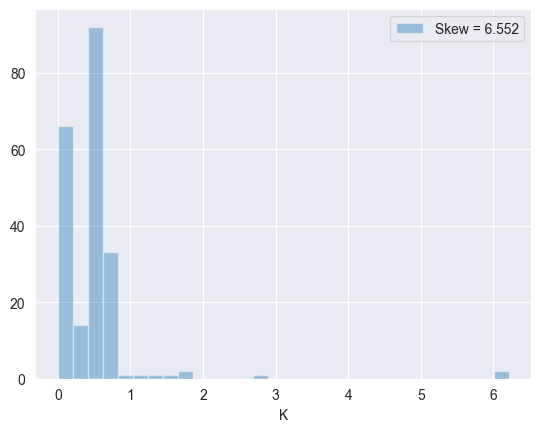

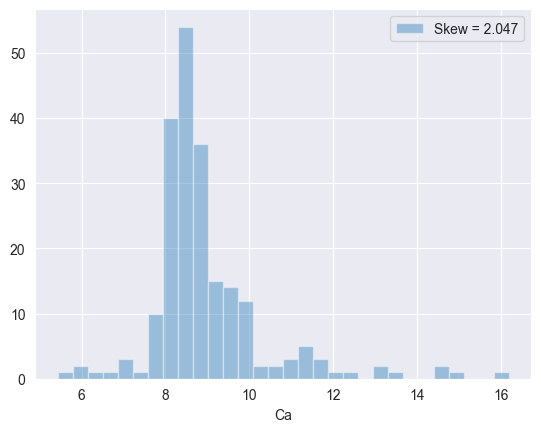

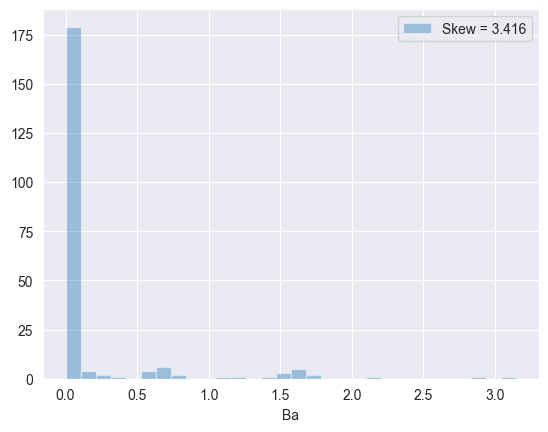

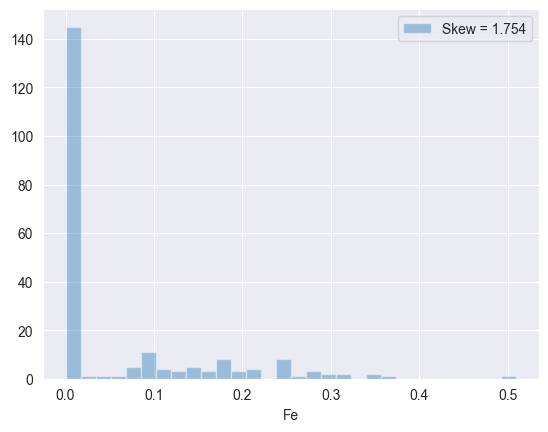

In [128]:
features = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

Можем видеть, что никакой признак не распределен нормально, причем Fe, Ba, Ca, K имеют наибольший сдвиг. K и Ba, к тому же, содержит большое количество выбросов. Мы можем найти наблюдения с выбросами

In [129]:
def outlier_hunt(df):
    outlier_indices = []
    for col in df.columns.tolist():
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > 2 )

    return multiple_outliers

print('The dataset contains %d observations with more than 2 outliers' % (len(outlier_hunt(df[features]))))

The dataset contains 14 observations with more than 2 outliers


Получили, что у нас 14 наблюдений с несколькими выбросами.

Посмотрим на распределения всех признаков в целом

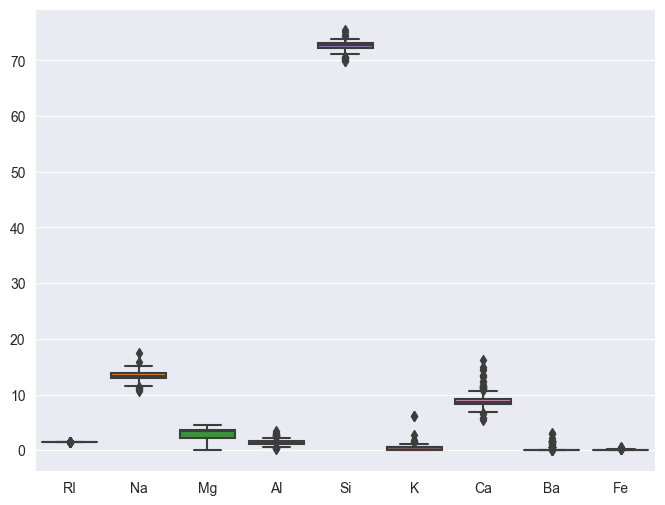

In [130]:
plt.figure(figsize=(8,6))
sns.boxplot(df[features])
plt.show()

Получили, что кремний Si очень сильно превосходит по значениям.

Посмотрим на корреляцию признаков

<Figure size 800x800 with 0 Axes>

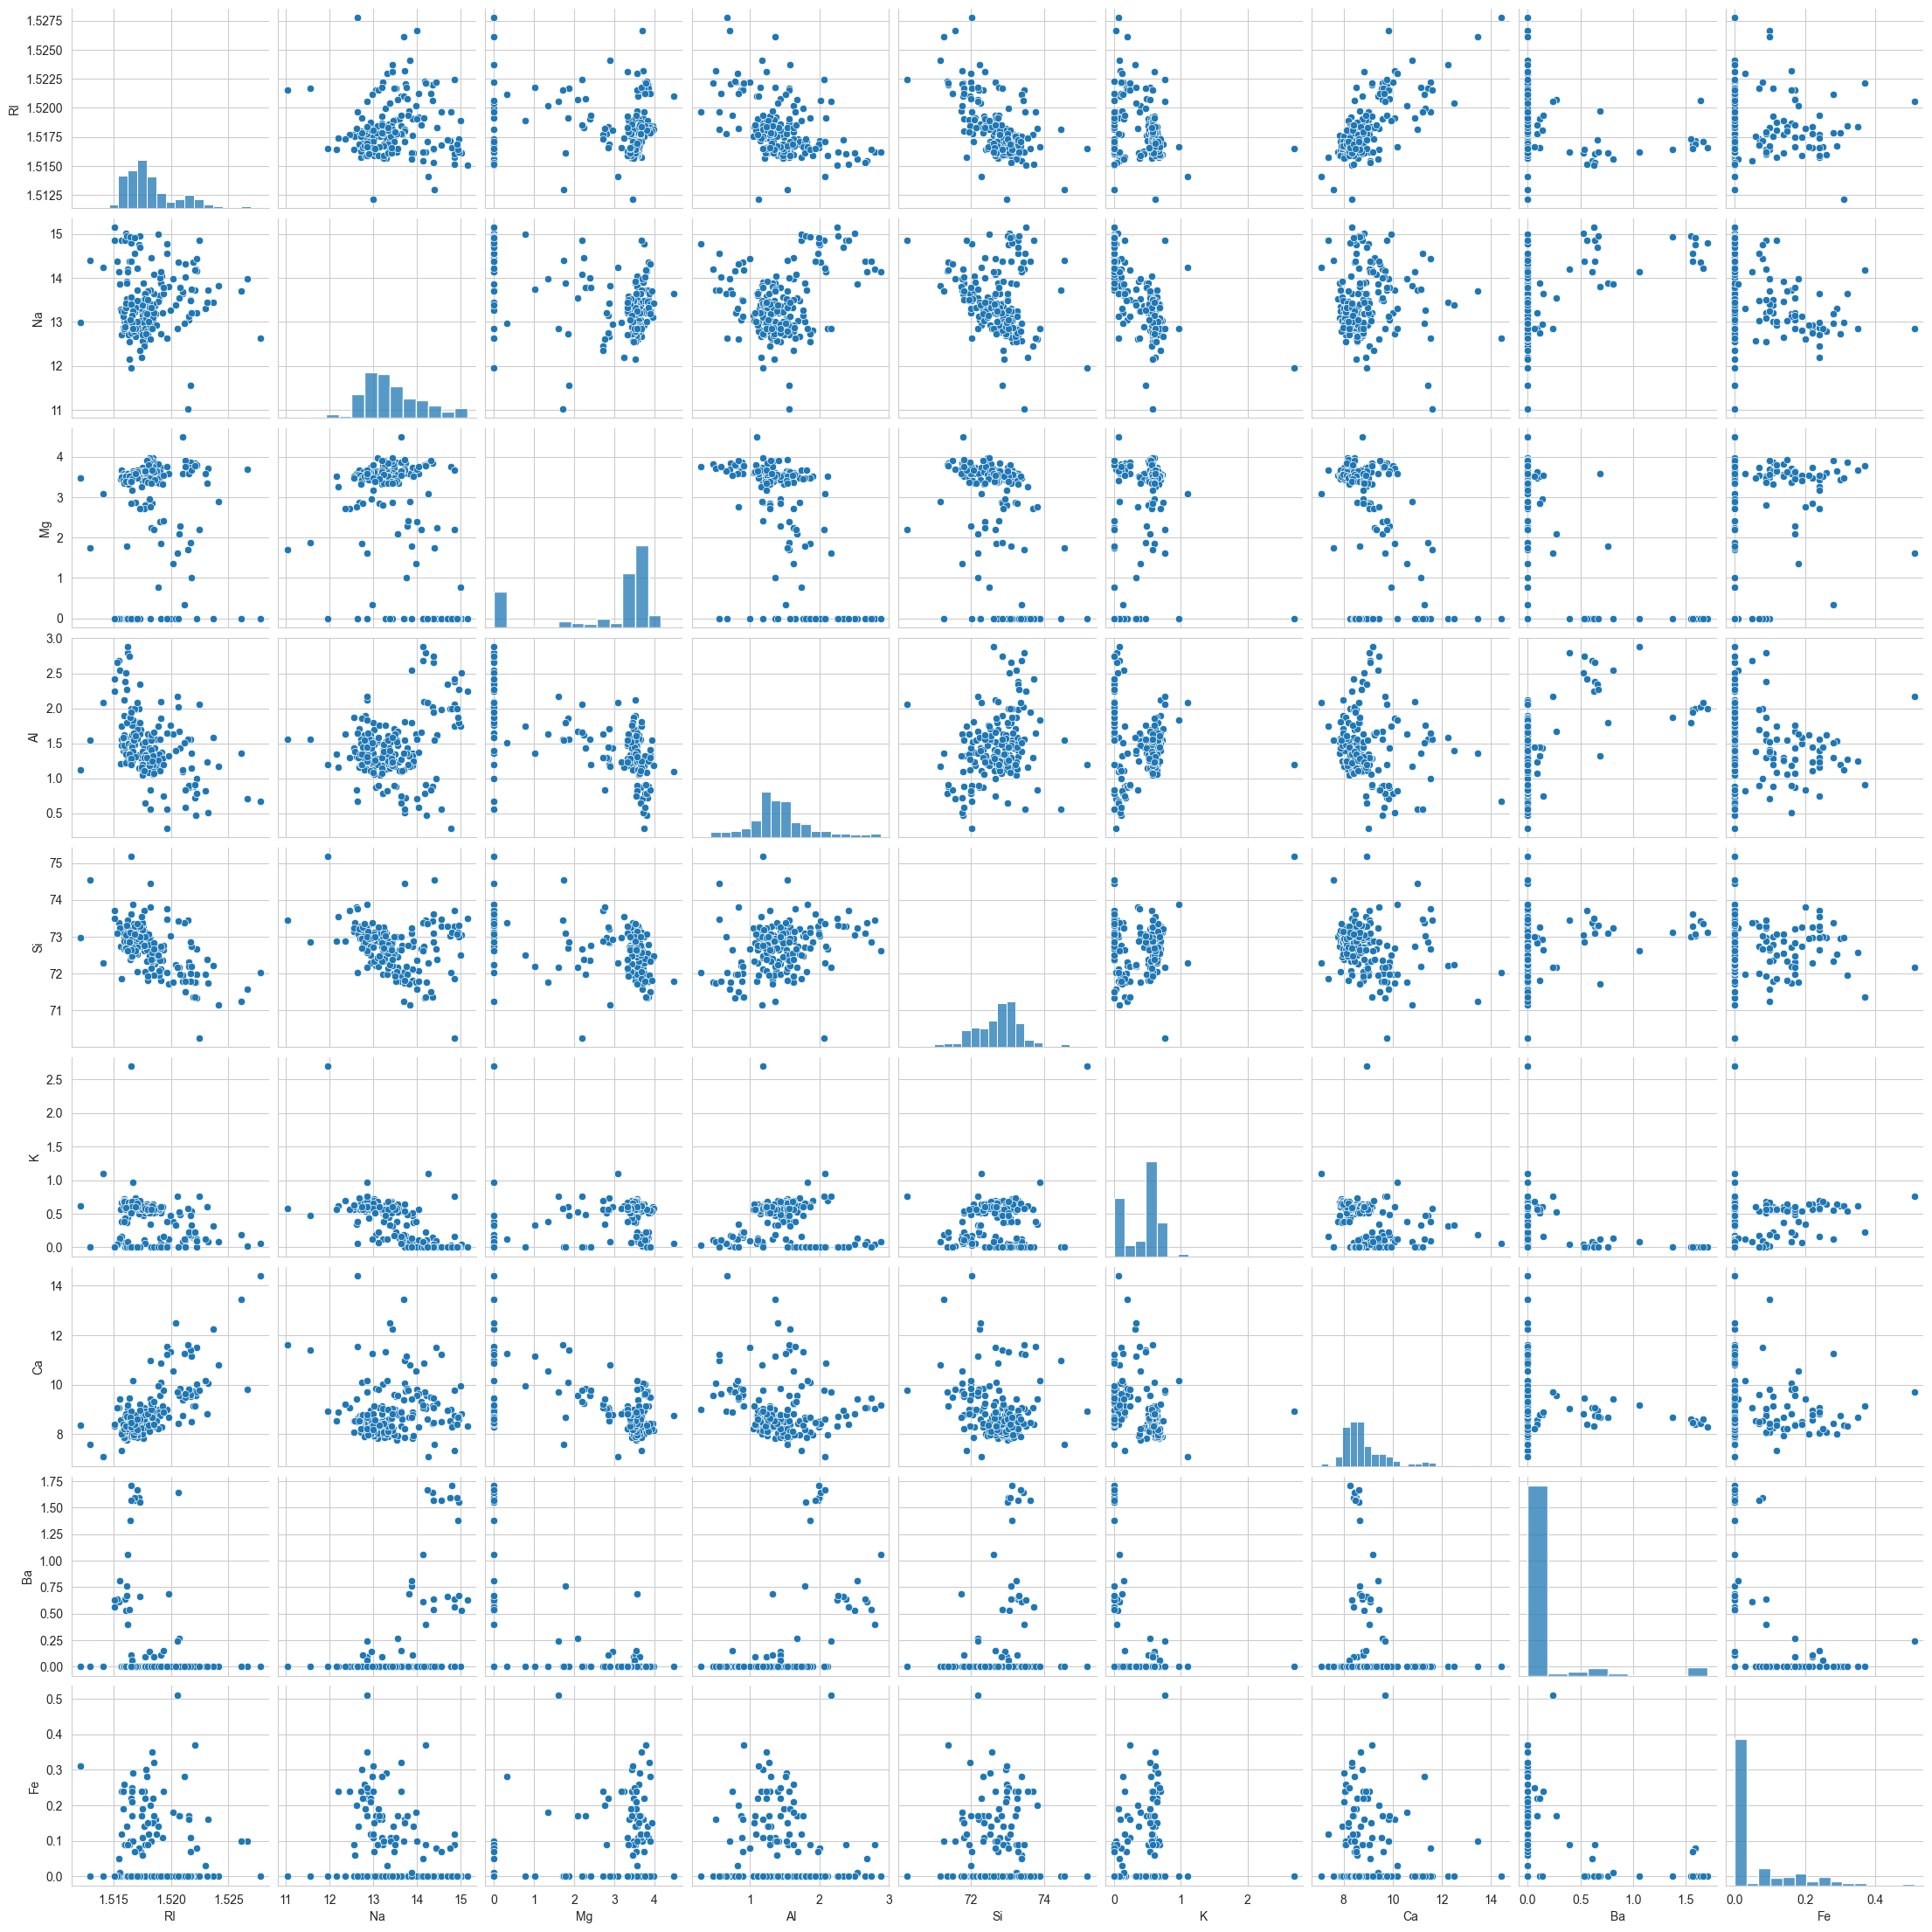

In [193]:
plt.figure(figsize=(8,8))
sns.pairplot(df[features])
plt.show()

<AxesSubplot: >

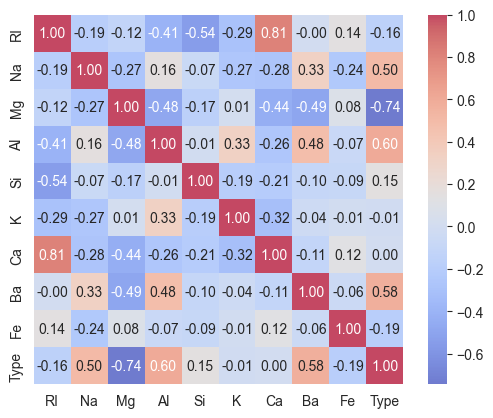

In [132]:
corr = df.corr()
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 10}, alpha = 0.7,   cmap= 'coolwarm')

Можем сделать следующие выводы:
- Есть большая корреляция между Ri и Ca.
- Есть корреляция между Ba и Type, Al и Type, Na и Type

# Feature Engineering

## Избавление от выбросов

In [133]:
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
df.shape

(200, 10)

## Разделение выборки

In [135]:
X = df[features]
y = df['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=7)

# Подбор гиперпараметров

Для удобства воспользуемся пайплайном, в котором будем производить масштабирование и подбор наилучших признаков.

Также, при подборе гиперпараметров воспользуемся метрикой roc_auc.

# Логистическая регрессия

In [163]:
def pipeline_logistic_regression(C=1.0):
    pipeline = Pipeline(
        steps=[
            ("scaling", StandardScaler()),
            ("rfe", RFECV(estimator=LogisticRegression())),
            ("classification", LogisticRegression(C=C, max_iter=10000)),
        ]
    )
    return pipeline

In [152]:
C_grid = np.arange(1e-05, 5, 0.1)
searcher = GridSearchCV(
    pipeline_logistic_regression(),
    [{"classification__C": C_grid}],
    scoring="roc_auc_ovr",
    error_score="raise",
    cv=5,
)
searcher.fit(X_train, y_train)

optimal_C_LR = searcher.best_params_["classification__C"]
searcher.best_params_

{'classification__C': 4.60001}

# SVM

In [165]:
def pipeline_svm(C=1.0):
    pipeline = Pipeline(
        steps=[
            ("scaling", StandardScaler()),
            ("rfe", RFECV(estimator=LogisticRegression())),
            (
                "classification",
                SVC(C=C, probability=True),
            ),
        ]
    )
    return pipeline

In [154]:
C_grid = np.logspace(-5, 3, 20)
searcher = GridSearchCV(
    pipeline_svm(),
    [{"classification__C": C_grid}],
    scoring="roc_auc_ovr",
    cv=5,
    error_score="raise",
)
searcher.fit(X_train, y_train)
optimal_C_SVM = searcher.best_params_["classification__C"]
searcher.best_params_

{'classification__C': 7.847599703514607}

# KNN

In [168]:
def pipeline_knn(n_neighbors=3):
    pipeline = Pipeline(
        steps=[
            ("scaling", StandardScaler()),
            ("rfe", RFECV(estimator=LogisticRegression())),
            (
                "classification",
                KNeighborsClassifier(n_neighbors=n_neighbors),
            ),
        ]
    )
    return pipeline

In [156]:
n_neighbors_grid = np.arange(1, 11, 2)
searcher = GridSearchCV(
    pipeline_knn(),
    [
        {
            "classification__n_neighbors": n_neighbors_grid,
        }
    ],
    scoring="roc_auc_ovr",
    cv=5,
    error_score="raise",
)
searcher.fit(X_train, y_train)

optimal_n_neighbors = searcher.best_params_["classification__n_neighbors"]
searcher.best_params_

{'classification__n_neighbors': 9}

# Naive Bayes

In [167]:
def pipeline_nb(var_smoothing=1e-09):
    pipeline = Pipeline(
        steps=[
            ("scaling", StandardScaler()),
            ("rfe", RFECV(estimator=LogisticRegression())),
            (
                "classification",
                GaussianNB(var_smoothing=var_smoothing),
            ),
        ]
    )
    return pipeline

In [158]:
var_smoothing_grid = np.logspace(0, -9, num=50)
searcher = GridSearchCV(
    pipeline_nb(),
    [
        {
            "classification__var_smoothing": var_smoothing_grid,
        }
    ],
    scoring="roc_auc_ovr",
    cv=5,
    error_score="raise",
)
searcher.fit(X_train, y_train)
optimal_var_smoothing = searcher.best_params_["classification__var_smoothing"]

# Decision Tree

In [166]:
def pipeline_decision_tree(max_depth=10, min_samples_split=2, min_samples_leaf=1):
    pipeline = Pipeline(
        steps=[
            ("scaling", StandardScaler()),
            ("rfe", RFECV(estimator=LogisticRegression())),
            (
                "classification",
                DecisionTreeClassifier(
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                ),
            ),
        ]
    )
    return pipeline

In [160]:
depths_grid = np.arange(7, 15)
min_samples_splits_grid = [2, 4, 5, 10, 7]
min_samples_leafs_grid = [1, 2, 3, 4, 6]

searcher = GridSearchCV(
    pipeline_decision_tree(),
    [
        {
            "classification__max_depth": depths_grid,
            "classification__min_samples_split": min_samples_splits_grid,
            "classification__min_samples_leaf": min_samples_leafs_grid,
        }
    ],
    scoring="roc_auc_ovr",
    cv=5,
    error_score="raise",
)
searcher.fit(X_train, y_train)

optimal_depth = searcher.best_params_["classification__max_depth"]
optimal_min_samples_split = searcher.best_params_["classification__min_samples_split"]
optimal_min_samples_leaf = searcher.best_params_["classification__min_samples_leaf"]
searcher.best_params_

{'classification__max_depth': 14,
 'classification__min_samples_leaf': 6,
 'classification__min_samples_split': 5}

# Сравнение моделей

## Подготовка

In [170]:
def measure_time(model, X, y):
    return cross_validate(model, X, y, cv=5)["fit_time"].mean()

accs = {}
times = {}

## OneVsRest

### Logistic Regression

In [171]:
lr_pipe = pipeline_logistic_regression(optimal_C_LR)
lr_pipe = OneVsRestClassifier(lr_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, lr_pipe.predict(X_test))
t = measure_time(lr_pipe, X_train, y_train)
accs["OVR_LR"] = acc
times["OVR_LR"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.625
Mean time 1.109936571121216


### SVM

In [172]:
svm_pipe = pipeline_svm(optimal_C_SVM)
svm_pipe = OneVsRestClassifier(svm_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, svm_pipe.predict(X_test))
t = measure_time(svm_pipe, X_train, y_train)
accs["OVR_SVM"] = acc
times["OVR_SVM"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.575
Mean time 1.0161541938781737


### KNN

In [173]:
knn_pipe = pipeline_knn(optimal_n_neighbors)
knn_pipe = OneVsRestClassifier(knn_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, knn_pipe.predict(X_test))
t = measure_time(knn_pipe, X_train, y_train)
accs["OVR_KNN"] = acc
times["OVR_KNN"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.6
Mean time 1.0376076698303223


### Naive Bayes

In [174]:
nb_pipe = pipeline_nb(optimal_var_smoothing)
nb_pipe = OneVsRestClassifier(nb_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, nb_pipe.predict(X_test))
t = measure_time(nb_pipe, X_train, y_train)
accs["OVR_NB"] = acc
times["OVR_NB"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.525
Mean time 1.0321362495422364


### Decision Tree

In [175]:
dt_pipe = pipeline_decision_tree(
    optimal_depth, optimal_min_samples_split, optimal_min_samples_leaf
)
dt_pipe = OneVsRestClassifier(dt_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, dt_pipe.predict(X_test))
t = measure_time(dt_pipe, X_train, y_train)
accs["OVR_DT"] = acc
times["OVR_DT"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.75
Mean time 0.9566408157348633


## OneVsOne

### Logistic Regression

In [176]:
lr_pipe = pipeline_logistic_regression(optimal_C_LR)
lr_pipe = OneVsOneClassifier(lr_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, lr_pipe.predict(X_test))
t = measure_time(lr_pipe, X_train, y_train)
accs["OVO_LR"] = acc
times["OVO_LR"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.675
Mean time 2.1159676551818847


### SVM

In [177]:
svm_pipe = pipeline_svm(optimal_C_SVM)
svm_pipe = OneVsOneClassifier(svm_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, svm_pipe.predict(X_test))
t = measure_time(svm_pipe, X_train, y_train)
accs["OVO_SVM"] = acc
times["OVO_SVM"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.625
Mean time 2.297598123550415


### KNN

In [178]:
knn_pipe = pipeline_knn(optimal_n_neighbors)
knn_pipe = OneVsOneClassifier(knn_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, knn_pipe.predict(X_test))
t = measure_time(knn_pipe, X_train, y_train)
accs["OVO_KNN"] = acc
times["OVO_KNN"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.625
Mean time 2.1660493850708007


### Naive Bayes

In [179]:
nb_pipe = pipeline_nb(optimal_var_smoothing)
nb_pipe = OneVsOneClassifier(nb_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, nb_pipe.predict(X_test))
t = measure_time(nb_pipe, X_train, y_train)
accs["OVO_NB"] = acc
times["OVO_NB"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.5
Mean time 2.227381181716919


### Decision Tree

In [180]:
dt_pipe = pipeline_decision_tree(
    optimal_depth, optimal_min_samples_split, optimal_min_samples_leaf
)
dt_pipe = OneVsOneClassifier(dt_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, dt_pipe.predict(X_test))
t = measure_time(dt_pipe, X_train, y_train)
accs["OVO_DT"] = acc
times["OVO_DT"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.7
Mean time 2.298468732833862


## Output Code

### Logistic Regression

In [184]:
lr_pipe = pipeline_logistic_regression(optimal_C_LR)
lr_pipe = OutputCodeClassifier(lr_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, lr_pipe.predict(X_test))
t = measure_time(lr_pipe, X_train, y_train)
accs["OC_LR"] = acc
times["OC_LR"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.725
Mean time 1.4099137783050537


### SVM

In [185]:
svm_pipe = pipeline_svm(optimal_C_SVM)
svm_pipe = OutputCodeClassifier(svm_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, svm_pipe.predict(X_test))
t = measure_time(svm_pipe, X_train, y_train)
accs["OC_SVM"] = acc
times["OC_SVM"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.725
Mean time 1.4735655307769775


### KNN

In [186]:
knn_pipe = pipeline_knn(optimal_n_neighbors)
knn_pipe = OutputCodeClassifier(knn_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, knn_pipe.predict(X_test))
t = measure_time(knn_pipe, X_train, y_train)
accs["OC_KNN"] = acc
times["OC_KNN"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.7
Mean time 1.440117073059082


### Naive Bayes

In [187]:
nb_pipe = pipeline_nb(optimal_var_smoothing)
nb_pipe = OutputCodeClassifier(nb_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, nb_pipe.predict(X_test))
t = measure_time(nb_pipe, X_train, y_train)
accs["OC_NB"] = acc
times["OC_NB"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.45
Mean time 1.41288161277771


### Decision Tree

In [188]:
dt_pipe = pipeline_decision_tree(
    optimal_depth, optimal_min_samples_split, optimal_min_samples_leaf
)
dt_pipe = OutputCodeClassifier(dt_pipe).fit(X_train, y_train)
acc = accuracy_score(y_test, dt_pipe.predict(X_test))
t = measure_time(dt_pipe, X_train, y_train)
accs["OC_DT"] = acc
times["OC_DT"] = t
print(f"Test accuracy {acc}")
print(f"Mean time {t}")

Test accuracy 0.725
Mean time 1.6114527702331543


## Сравнение моделей

## Accuracy

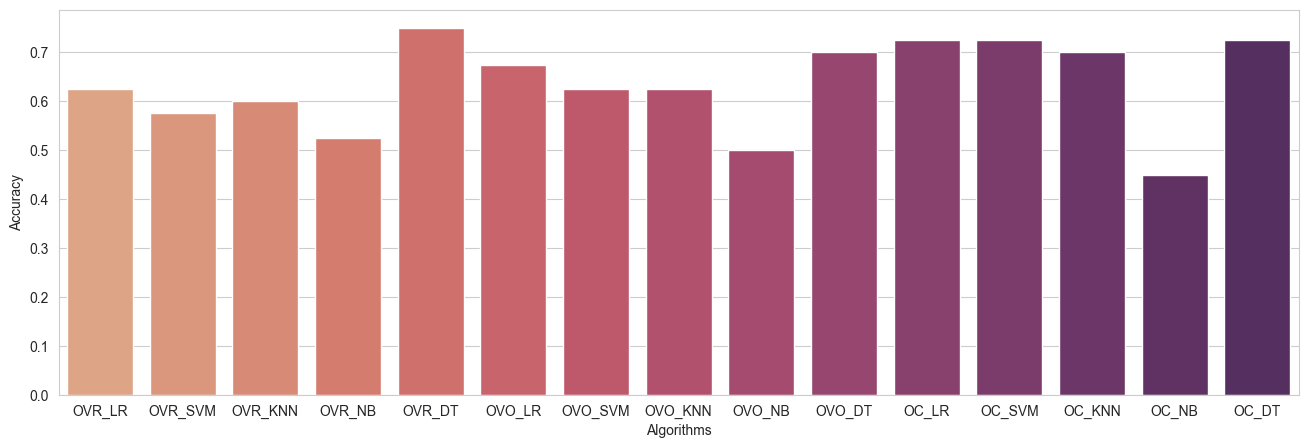

In [189]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=list(accs.keys()), y=list(accs.values()), palette=sns.color_palette("flare", len(times)))
plt.show()

## Время

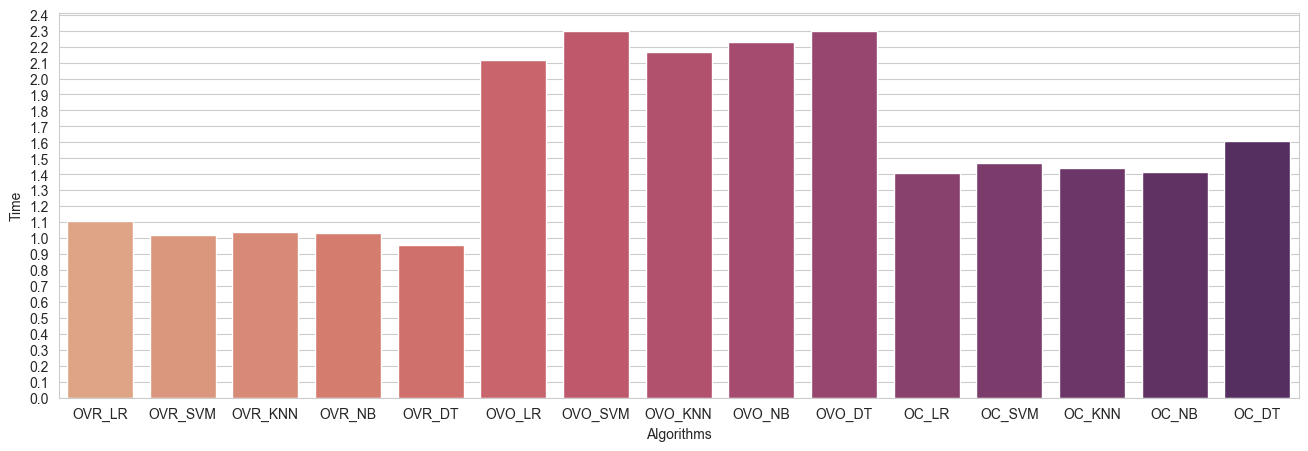

In [192]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 5, 0.1))
plt.ylabel("Time")
plt.xlabel("Algorithms")
sns.barplot(x=list(times.keys()), y=list(times.values()), palette=sns.color_palette("flare", len(times)))
plt.show()

# Выводы

- По точности лучше всех себя показала стратегия OutputCode
- По точности хуже всех себя показала стратегия OneVsRest
- Хуже всех себя показал Naive Bayes среди других моделей для всех классификаций
- Лучше всех себя показал Decision Tree среди других моделей для всех классификаций
- Медленнее всего сработал OneVsOne
- Быстрее всего сработал OneVsRest